<a href="https://colab.research.google.com/github/lychee1223/2023IyatomiLabCompetition/blob/main/2023IyatomiLabCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリの準備

In [ ]:
!pip install kaggle timm ultralytics

In [2]:
# データ解析系
import numpy as np
import pandas as pd
import cv2

# データ整形系
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tqdm import tqdm

# ファイル操作系
from google.colab import files
import zipfile
import glob

import random
import time
import os
import os.path as osp

# 機械学習系
import timm

from ultralytics import YOLO

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

# データセットのダウンロード

In [ ]:
!wget https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification/download?datasetVersionNumber=2

In [4]:
# kaggleのAPI認証
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name = fn, length = len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [5]:
#データセットをダウンロード
!kaggle competitions download -c 2023-iyatomilab-competition

# データセットを解凍
zip_file = zipfile.ZipFile('/content/2023-iyatomilab-competition.zip')
zip_file.extractall('/content/2023-iyatomilab-competition/')

 99% 146M/148M [00:10<00:00, 18.5MB/s]
100% 148M/148M [00:10<00:00, 14.8MB/s]


In [6]:
# ラベルの辞書を定義
train_df = pd.read_csv('/content/2023-iyatomilab-competition/train.csv')

label_dict = dict(sorted(zip(train_df['number'], train_df['label'])))
label_dict

{0: '4runner',
 1: 'avalon',
 2: 'camry',
 3: 'corolla',
 4: 'highlander',
 5: 'hilux',
 6: 'prius',
 7: 'rav4',
 8: 'sienna',
 9: 'tacoma',
 10: 'tundra',
 11: 'yaris'}

# Yolo v8による車両の切り抜き

In [ ]:
'''学習データの物体を検出'''
model = YOLO('yolov8l.pt')  # モデルをロード

TRAIN_ORIGINAL_PATH = '/content/2023-iyatomilab-competition/train/train/'
TRAIN_CROP_PATH = '/content/2023-iyatomilab-competition/train/crop/'

for i in range(len(label_dict)):
    # 各クラスの画像のパスを作成
    path = f'{TRAIN_ORIGINAL_PATH}{label_dict[i]}/*.jpg'
    original_files = glob.glob(path)

    for f in tqdm(original_files):
        # Yoloで各画像の物体を検出
        results = model(f)
        original_img = cv2.imread(f)

        # 最大面積のバウンディング・ボックスを探索
        max_area = 0
        max_box = None
        for j, box in enumerate(results[0].boxes.xyxy.tolist()):
            x1, y1, x2, y2 = box
            area = (x2 - x1) * (y2 - y1)
            if area > max_area:
                max_area = area
                max_box = box

        # 画像を保存するディレクトリを作成
        if not osp.exists(f'{TRAIN_CROP_PATH}{label_dict[i]}/'):
            os.makedirs(f'{TRAIN_CROP_PATH}{label_dict[i]}/')

        # 最大面積のバウンディング・ボックスをCropし、保存
        if max_box is not None:
            x1, y1, x2, y2 = max_box
            crop_img = original_img[int(y1) : int(y2), int(x1) : int(x2)]

            file_name = osp.splitext(osp.basename(f))[0]
            cv2.imwrite(f"{TRAIN_CROP_PATH}{label_dict[i]}/{file_name}.jpg", crop_img)

        # 検出されたオブジェクトがなかった場合、オリジナル画像を保存
        else:
            file_name = osp.splitext(osp.basename(f))[0]
            cv2.imwrite(f"{TRAIN_CROP_PATH}{label_dict[i]}/{file_name}.jpg", original_img)

In [ ]:
'''テストデータの物体を検出'''
model = YOLO('yolov8l.pt')  # モデルをロード

TEST_ORIGINAL_PATH = '/content/2023-iyatomilab-competition/test/test/'
TEST_CROP_PATH = '/content/2023-iyatomilab-competition/test/crop/'

# 各クラスの画像のパスを作成
path = f'{TEST_ORIGINAL_PATH}*.jpg'
original_files = sorted(glob.glob(path))

for f in tqdm(original_files):
    # Yoloで各画像の物体を検出
    results = model(f)
    original_img = cv2.imread(f)

    # 最大面積のバウンディング・ボックスを探索
    max_area = 0
    max_box = None
    for j, box in enumerate(results[0].boxes.xyxy.tolist()):
        x1, y1, x2, y2 = box
        area = (x2 - x1) * (y2 - y1)
        if area > max_area:
            max_area = area
            max_box = box

    # 画像を保存するディレクトリを作成
    if not osp.exists(f'{TEST_CROP_PATH}'):
        os.makedirs(f'{TEST_CROP_PATH}')

    # 最大面積のバウンディング・ボックスをCropし、保存
    if max_box is not None:
        x1, y1, x2, y2 = max_box
        crop_img = original_img[int(y1) : int(y2), int(x1) : int(x2)]

        file_name = osp.splitext(osp.basename(f))[0]
        cv2.imwrite(f"{TEST_CROP_PATH}{file_name}.jpg", crop_img)

    # 検出されたオブジェクトがなかった場合、オリジナル画像を保存
    else:
        file_name = osp.splitext(osp.basename(f))[0]
        cv2.imwrite(f"{TEST_CROP_PATH}{file_name}.jpg", original_img)

# データの確認

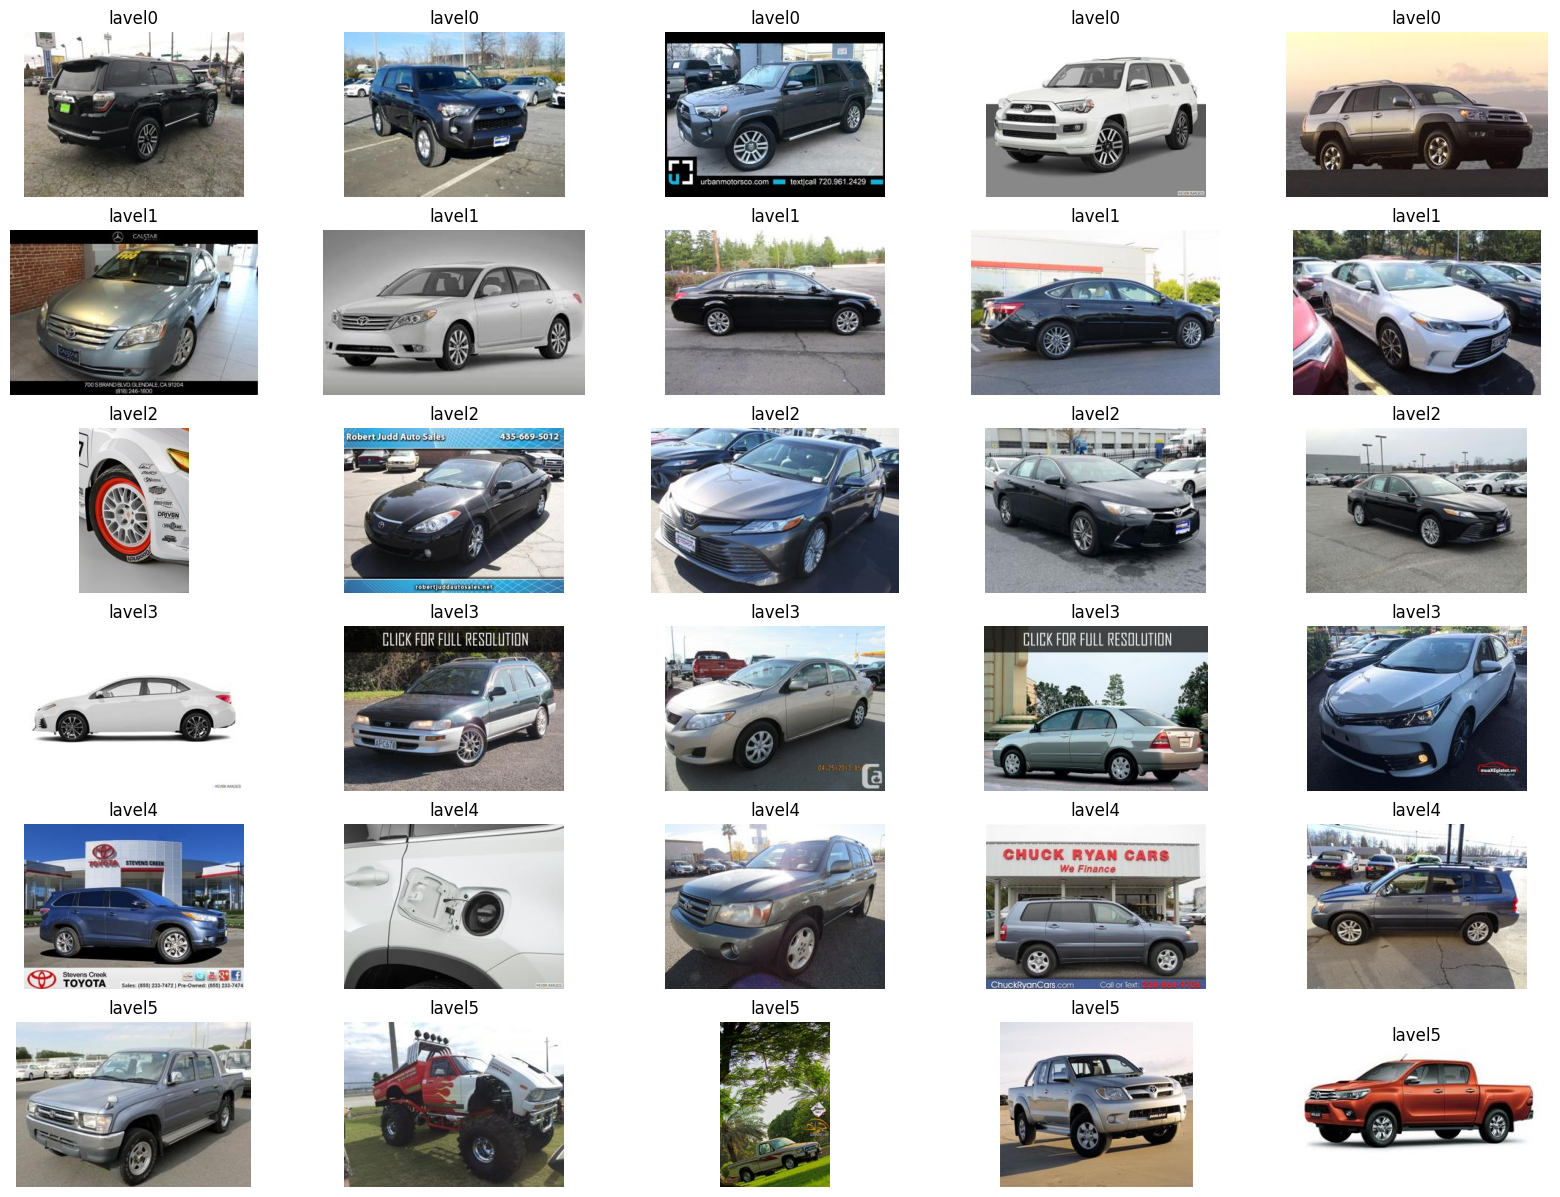

In [9]:
# 学習データセットの作成
l = 6
m = 5
n = 0

plt.figure(figsize=( 20 , 15 ))

for i in range(len(label_dict)):
  if i < 6:
    path = f'{TRAIN_ORIGINAL_PATH}{label_dict[i]}/*.jpg'  # 各ラベルのデータのパスを作成
    filelist = glob.glob(path)

    count = 0
    # 各データを順に格納
    for f in filelist:
        count += 1
        if count > 5:
          break

        image = Image.open(f)
        n += 1
        plt.subplot(l, m, n)
        plt.imshow(image,cmap = "gray")
        plt.title(f'lavel{i}')
        plt.axis("off")

plt.show()

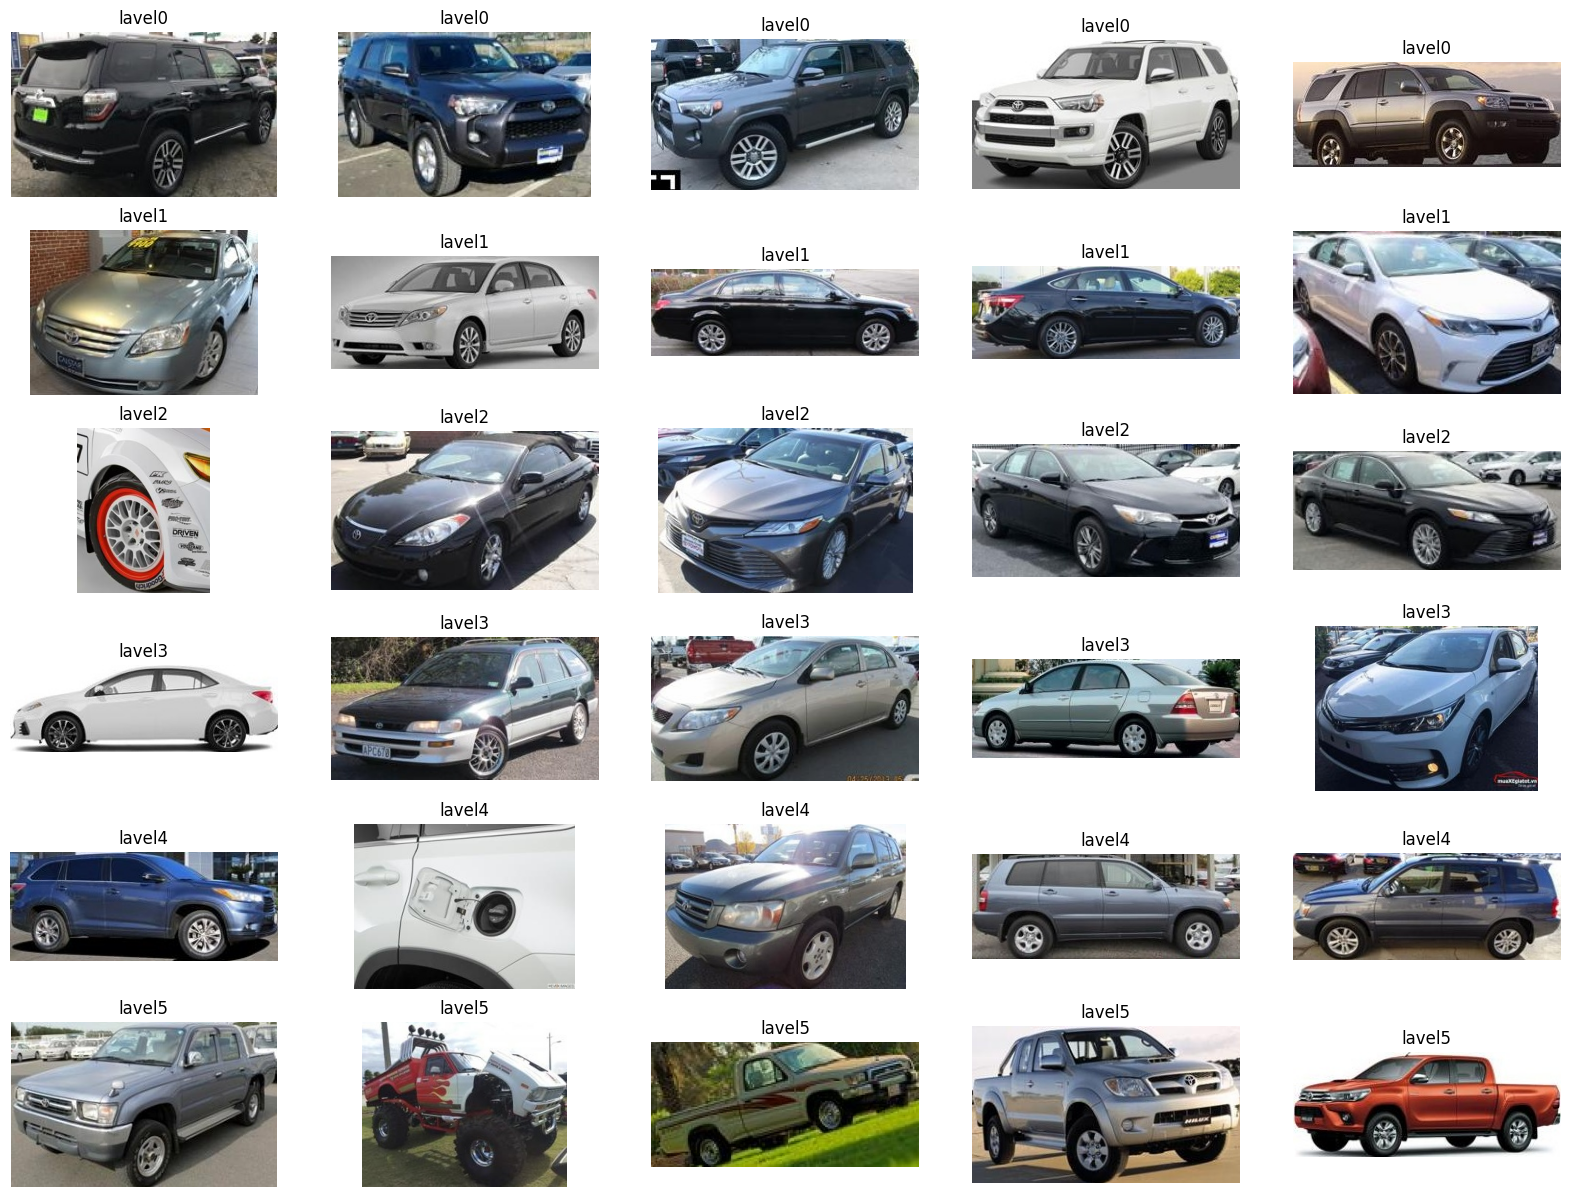

In [10]:
# 学習データセットの作成
l = 6
m = 5
n = 0

plt.figure(figsize=( 20 , 15 ))

for i in range(len(label_dict)):
  if i < 6:
    path = f'{TRAIN_CROP_PATH}{label_dict[i]}/*.jpg'  # 各ラベルのデータのパスを作成
    filelist = glob.glob(path)

    count = 0
    # 各データを順に格納
    for f in filelist:
        count += 1
        if count > 5:
          break

        image = Image.open(f)
        n += 1
        plt.subplot(l, m, n)
        plt.imshow(image,cmap = "gray")
        plt.title(f'lavel{i}')
        plt.axis("off")

plt.show()

# データセットの準備

In [11]:
'''学習データのパスとラベルをリストに格納'''
pathes, labels = [], []

for i in range(len(label_dict)):
    # 各クラスの画像のパスを作成
    path = f'{TRAIN_CROP_PATH}{label_dict[i]}/*.jpg'
    crop_files = glob.glob(path)

    for f in crop_files:
        pathes.append(f)
        labels.append(i)

In [12]:
'''データセットの分割'''
SEED_VALUE = 0
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

# データをtrain, testに分割
train_pathes, val_pathes, train_labels, val_labels = train_test_split(
    pathes,
    labels,
    test_size=0.01,
    random_state=SEED_VALUE,
    stratify=labels,
    shuffle=True
)

In [13]:
'''各ラベルの枚数を確認する関数を定義'''
def count_class_size(labels):
    unique_labels = np.unique(labels, return_counts=True)
    count_dict = {}
    for i in range(len(label_dict)):
      count_dict[unique_labels[0][i]] = unique_labels[1][i]

    return count_dict

In [14]:
# 学習データの枚数
count_class_size(train_labels)

{0: 203,
 1: 104,
 2: 485,
 3: 514,
 4: 222,
 5: 102,
 6: 229,
 7: 368,
 8: 134,
 9: 291,
 10: 225,
 11: 181}

In [15]:
# 検証データの枚数
count_class_size(val_labels)

{0: 2, 1: 1, 2: 5, 3: 5, 4: 2, 5: 1, 6: 2, 7: 4, 8: 2, 9: 3, 10: 2, 11: 2}

#Transform・DataSet・DataLoaderの作成

In [16]:
'''学習データ用transformersの定義'''
class TrainTransforms:
    def __init__(self, input_size=384) -> None:
        self.transforms = transforms.Compose(
            [
                transforms.RandAugment(5, 15),
                transforms.AugMix(3, 3),
                transforms.Resize((input_size,input_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                transforms.RandomErasing(0.1)
            ]
        )

    def __call__(self, img):
        return self.transforms(img)

'''検証・テストデータ用transformersの定義'''
class ValTransforms:
    def __init__(self, input_size=384) -> None:
        self.transforms = transforms.Compose(
            [
                transforms.Resize((input_size,input_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)), # 正規化
            ]
        )

    def __call__(self, img):
        return self.transforms(img)

In [17]:
'''カスタムデータセットの定義'''
class CustomDataset(Dataset):
    def __init__(self, pathes, labels, transform):
        self.pathes = pathes
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.pathes)

    def __getitem__(self, idx):
        path = self.pathes[idx]
        img = Image.open(path)

        label = self.labels[idx]

        # 前処理
        if self.transform:
            img = self.transform(img)

        return img, label

In [18]:
# データセットの作成
train_dataset = CustomDataset(train_pathes, train_labels, TrainTransforms())
val_dataset = CustomDataset(val_pathes, val_labels, ValTransforms())


# データローダーの作成
train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    pin_memory=True
)

val_dataloader = DataLoader(val_dataset,
                            batch_size=128,
                            shuffle=True,
                            pin_memory=True)

dataloaders = {'train':train_dataloader, 'val':val_dataloader}

# モデルの準備

In [19]:
# model_name = 'resnetv2_50d_gn.ah_in1k'
# model_name = 'resnet18d.ra2_in1k'
model_name = 'resnet152.tv2_in1k'
# model_name = 'tf_efficientnet_b0'
# model_name = 'tf_efficientnetv2_s_in21ft1k'
# model_name = 'tf_efficientnetv2_m.in21k_ft_in1k'
# model_name = 'tf_efficientnetv2_xl.in21k_ft_in1k'
# model_name = 'vit_base_patch16_224.augreg2_in21k_ft_in1k'

model = timm.create_model(model_name, pretrained=True, num_classes=len(label_dict))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

# 学習

In [20]:
def train(model, train_dataloader, val_dataloader, optimizer, criterion, max_epoch):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    model.to(device)

    print(f'使用デバイス：{device}')

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    scaler = torch.cuda.amp.GradScaler()

    train_losses, val_losses, train_f1s, val_f1s = [], [], [], []

    print("Start training...")
    for epoch in range(max_epoch):
        print(f'\nepoch [{epoch+1}/{max_epoch}]')
        train_loss, val_loss = 0.0, 0.0

        '''学習'''
        model.train()
        f1_list, label_list = [], []
        for imgs, labels in tqdm(train_dataloader):
            train_imgs = imgs.to(device)
            train_labels = labels.to(device)

            optimizer.zero_grad() # optimizerを初期化

            # forward
            with torch.autocast(device_type=device.type):
                pred = model(train_imgs)
                loss = criterion(pred, train_labels)

            # backward
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


            # loss更新
            train_loss += loss.item()

            # macro_f1_score更新
            predicted = torch.argmax(pred, dim=1)
            f1_list.append(predicted.cpu().detach())
            label_list.append(train_labels.cpu().detach())

            del pred
            del loss
            del train_imgs
            del train_labels
            torch.cuda.empty_cache()

        # 1エポックの平均損失を記録
        train_loss /= len(train_dataloader)
        f1_list = torch.cat(f1_list, 0)
        label_list = torch.cat(label_list, 0)
        train_f1 = f1_score(f1_list.cpu(), label_list.cpu(), average='macro')

        '''検証'''
        model.eval()
        f1_list, label_list = [], []
        for imgs, labels in tqdm(val_dataloader):
            val_imgs = imgs.to(device)
            val_labels = labels.to(device)

            # forward
            with torch.autocast(device_type=device.type):
                pred = model(val_imgs)
                loss = criterion(pred, val_labels)

            # loss更新
            val_loss += loss.item()

            # macro_f1_score更新
            predicted = torch.argmax(pred, dim=1)
            f1_list.append(predicted.cpu().detach())
            label_list.append(val_labels.cpu().detach())

            del pred
            del loss
            del val_imgs
            del val_labels
            torch.cuda.empty_cache()

        # 1エポックの平均損失を記録
        val_loss /= len(val_dataloader)
        f1_list = torch.cat(f1_list, 0)
        label_list = torch.cat(label_list, 0)
        val_f1 = f1_score(f1_list.cpu(), label_list.cpu(), average='macro')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f'train_loss:{train_loss:4f}, train_f1:{train_f1:4f}')
        print(f'val_loss:{val_loss:4f}, val_f1:{val_f1:4f}')

    loss_history, f1_history = {}, {}
    loss_history['train_loss'] = train_losses
    loss_history['val_loss'] = val_losses
    f1_history['train_f1'] = train_f1s
    f1_history['val_f1'] = val_f1s

    print("Finish training!")
    return model, loss_history, f1_history

In [21]:
# 学習データ数の偏りに合わせてlossを重みづけ
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

class_size = list(count_class_size(train_labels).values())
weights = 1.0 / torch.Tensor(class_size).to(device)

In [22]:
lr = 1e-5
optimizer = torch.optim.RAdam(params=model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(weights)
max_epoch = 30

# 学習
model, train_history, f1_history = train(model, train_dataloader, val_dataloader, optimizer, criterion, max_epoch)

使用デバイス：cuda:0
Start training...

epoch [1/30]


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


train_loss:2.493873, train_f1:0.052031
val_loss:2.504948, val_f1:0.072685

epoch [2/30]


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


train_loss:2.491819, train_f1:0.062475
val_loss:2.503552, val_f1:0.033613

epoch [3/30]


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


train_loss:2.492742, train_f1:0.054424
val_loss:2.501780, val_f1:0.018519

epoch [4/30]


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


train_loss:2.490474, train_f1:0.062497
val_loss:2.499449, val_f1:0.033613

epoch [5/30]


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


train_loss:2.489194, train_f1:0.058671
val_loss:2.497873, val_f1:0.033613

epoch [6/30]


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


train_loss:2.487914, train_f1:0.060597
val_loss:2.495664, val_f1:0.034226

epoch [7/30]


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


train_loss:2.485454, train_f1:0.070409
val_loss:2.493348, val_f1:0.033613

epoch [8/30]


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


train_loss:2.485012, train_f1:0.060045
val_loss:2.491390, val_f1:0.034226

epoch [9/30]


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


train_loss:2.479057, train_f1:0.082177
val_loss:2.488776, val_f1:0.033613

epoch [10/30]


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


train_loss:2.479605, train_f1:0.070301
val_loss:2.485977, val_f1:0.075893

epoch [11/30]


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


train_loss:2.476929, train_f1:0.081732
val_loss:2.482450, val_f1:0.101190

epoch [12/30]


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


train_loss:2.475384, train_f1:0.091349
val_loss:2.480157, val_f1:0.089286

epoch [13/30]


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


train_loss:2.469635, train_f1:0.092656
val_loss:2.475625, val_f1:0.089286

epoch [14/30]


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


train_loss:2.466350, train_f1:0.101257
val_loss:2.470685, val_f1:0.117063

epoch [15/30]


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


train_loss:2.460228, train_f1:0.111069
val_loss:2.464106, val_f1:0.114087

epoch [16/30]


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


train_loss:2.454195, train_f1:0.117036
val_loss:2.456571, val_f1:0.158730

epoch [17/30]


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


train_loss:2.446165, train_f1:0.140336
val_loss:2.446447, val_f1:0.182540

epoch [18/30]


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


train_loss:2.435570, train_f1:0.148889
val_loss:2.434321, val_f1:0.165873

epoch [19/30]


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


train_loss:2.425514, train_f1:0.162463
val_loss:2.419104, val_f1:0.165873

epoch [20/30]


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


train_loss:2.403384, train_f1:0.184108
val_loss:2.391954, val_f1:0.232540

epoch [21/30]


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


train_loss:2.381793, train_f1:0.195975
val_loss:2.348362, val_f1:0.192063

epoch [22/30]


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


train_loss:2.344129, train_f1:0.229916
val_loss:2.285078, val_f1:0.262831

epoch [23/30]


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


train_loss:2.296025, train_f1:0.228156
val_loss:2.192238, val_f1:0.170833

epoch [24/30]


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


train_loss:2.239560, train_f1:0.246123
val_loss:2.102053, val_f1:0.240675

epoch [25/30]


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


train_loss:2.170629, train_f1:0.260113
val_loss:1.997682, val_f1:0.243056

epoch [26/30]


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


train_loss:2.100896, train_f1:0.281472
val_loss:1.917881, val_f1:0.308069

epoch [27/30]


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


train_loss:2.031188, train_f1:0.296036
val_loss:1.838713, val_f1:0.405952

epoch [28/30]


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


train_loss:1.955214, train_f1:0.324414
val_loss:1.772735, val_f1:0.422619

epoch [29/30]


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


train_loss:1.902104, train_f1:0.320764
val_loss:1.686605, val_f1:0.441865

epoch [30/30]


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


train_loss:1.851472, train_f1:0.334163
val_loss:1.632574, val_f1:0.444841
Finish training!


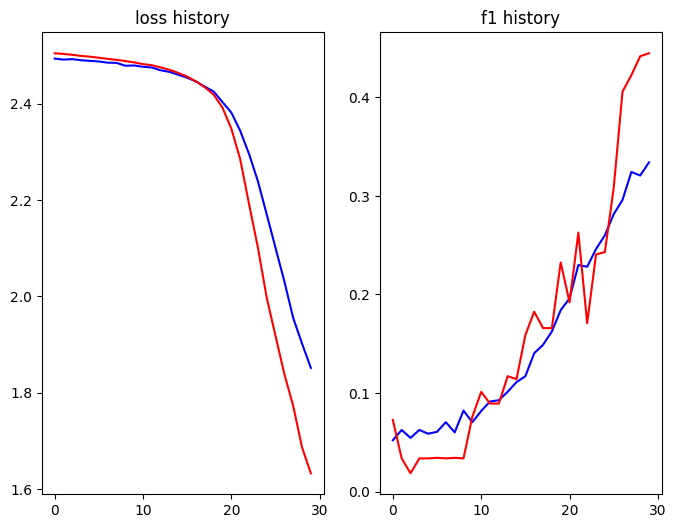

In [23]:
# 学習曲線の表示
plt.figure(figsize=(8,6))

plt.subplot(121)
plt.plot(train_history['train_loss'],label='train', c='b')
plt.plot(train_history['val_loss'],label='val', c='r')
plt.title('loss history')

plt.subplot(122)
plt.plot(f1_history['train_f1'],label='train', c='b')
plt.plot(f1_history['val_f1'],label='val', c='r')
plt.title('f1 history')

plt.show()

# 推論

In [24]:
'''推論'''
path = f'{TEST_CROP_PATH}*.jpg'
test_files = sorted(glob.glob(path))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
model.to(device)

pred_list = []
for path in tqdm(test_files):
    image = Image.open(path)
    transform = ValTransforms()
    image = transform(image)
    image = image[None].to(device)
    pred = torch.argmax(model(image))
    pred_list.append(int(pred))

sample_df = pd.read_csv('/content/2023-iyatomilab-competition/sample_submission.csv')
sample_df['number'] = pred_list
sample_df.to_csv(f'/content/output_{model_name}.csv', index=False, header=True)

100%|██████████| 9286/9286 [05:00<00:00, 30.95it/s]
